### Outcomes of the finer-grained extraction

The age and token counts from other notebooks {INSERT LINKS HERE} are for the whole document. This notebook contains the info related to token counts at specific locations in an FGDC or ISO record.

Three basic areas:

1. Does it have data quality (unrelated to a lineage)? A lineage? A metadata description? And, for FGDC, an attribute definition section?
2. What are the token and element counts for the lineage? the data quality (sans lineage)? the attribute definitions?
3. Does it have online resources in the distributions? Online refs, offline refs and nondigital refs for FGDC, online refs for ISO and are the online refs still accessible? Does this change over time (changes from more offline to online refs for fgdc or the linkrot)?

####Contents

[Raw lineage counts, contains processing steps](#raw_procsteps)

[Count of responses with lineage (processing steps) by protocol](#protocol_procsteps)

[Count of responses with lineage (processing steps or statement) by protocol](#protocol_procsteps_updated)

[Aggregated counts by month and year](#binned_procsteps)

[Distributions](#distributions)

In [3]:
%matplotlib inline
import pandas as pd
import json as js  # name conflict with sqla
import sqlalchemy as sqla
from sqlalchemy.orm import sessionmaker
from IPython.display import display
from IPython.display import Image

In [2]:
# grab the clean text from the rds
with open('../local/big_rds.conf', 'r') as f:
    conf = js.loads(f.read())

# our connection
engine = sqla.create_engine(conf.get('connection'))

<a id='raw_procsteps'></a>

In [8]:
# the worst way i could think of to count the booleans.
sql = """
with m as (
	select response_id, existences->'lineage' as has_lineage,
		existences->'attribute' as has_attribute,
		existences->'data_quality' as has_quality,
		existences->'metadata' as has_metadata
	from metadata_completeness
)

select r.host,
	sum(case when m.has_lineage::text = 'true' then 1 else 0 end) as count_w_lineage,
	sum(case when m.has_lineage::text != 'true' then 1 else 0 end) as count_wo_lineage
from responses r join m on m.response_id = r.id
group by r.host
order by count_w_lineage DESC;
"""

df = pd.read_sql(sql, engine)

In [10]:
with pd.option_context('display.max_rows', 100):
    display(df[:100])

,host,count_w_lineage,count_wo_lineage
0,catalog.data.gov,3293,4637
1,earthquake.usgs.gov,2850,0
2,pubs.usgs.gov,2711,67
3,gisdata.nd.gov,2066,1
4,meta.geo.census.gov,1729,46
5,www.landscape.blm.gov,1203,0
6,coast.noaa.gov,1018,250
7,rmgsc.cr.usgs.gov,979,92
8,data.usgs.gov,805,72
9,www.idwr.idaho.gov,653,54


<a id='protocol_procsteps'></a>

In [11]:
# let's do a quick protocol query
sql = """
with m as (
	select response_id, existences->'lineage' as has_lineage,
		existences->'attribute' as has_attribute,
		existences->'data_quality' as has_quality,
		existences->'metadata' as has_metadata
	from metadata_completeness
), i as (
	select d.response_id, jsonb_array_elements(d.identity::jsonb) ident
	from identities d
	where d.identity is not null
)

select i.ident->'protocol' as protocol,
	sum(case when m.has_lineage::text = 'true' then 1 else 0 end) as count_w_lineage,
	sum(case when m.has_lineage::text != 'true' then 1 else 0 end) as count_wo_lineage
	
from responses r join m on m.response_id = r.id
	join i on i.response_id = r.id
group by protocol
order by protocol;
"""

df = pd.read_sql(sql, engine)
df

,protocol,count_w_lineage,count_wo_lineage
0,FGDC,23053,3246
1,ISO,3681,15990


That is a little unexpected. However, bug in the system (ouch) where the lineage as statement only is not captured in the boolean value. It *is* in the token count set so all is not lost here. But! But I like knowing this - it is a one-to-one match with the FGDC as it stands this way, processing step to processing step. 

NOTE: I'm going to add another value, one for "complete" ISO lineage, ie processing steps or the statement, but keep the original "lineage" param as is.

I am sticking with my speculation that the switch from atomically structured lineages to a blob of text is related to changes in the interfaces. To know this, we'd have to know *how* the metadata was generated (did you fill out geoportal/geonetwork form? type into oxygen? provide a word file?) and the system it came out of (the usgin (i think) example was concatenated from something so it's a representation problem?).

<a id='binned_procsteps'></a>

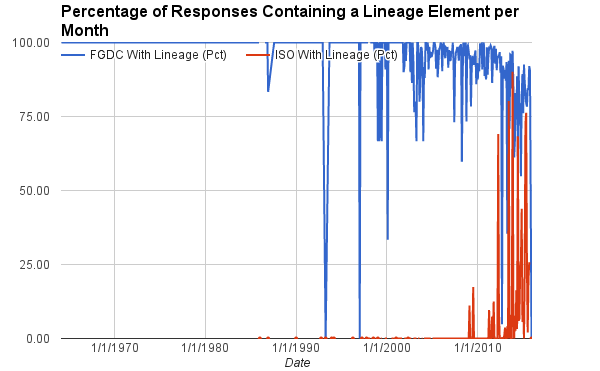

In [5]:
# to get the counts by protocol by month
sql = """
with m as (
	select response_id, existences->'lineage' as has_lineage,
		existences->'attribute' as has_attribute,
		existences->'data_quality' as has_quality,
		existences->'metadata' as has_metadata
	from metadata_completeness
), i as (
	select d.response_id, jsonb_array_elements(d.identity::jsonb) ident
	from identities d
	where d.identity is not null
)

select i.ident->'protocol' as protocol, date_trunc('month', r.metadata_age)::date as published,
	sum(case when m.has_lineage::text = 'true' then 1 else 0 end) as count_w_lineage,
	sum(case when m.has_lineage::text != 'true' then 1 else 0 end) as count_wo_lineage
	
from responses r join m on m.response_id = r.id
	join i on i.response_id = r.id
group by protocol, published
order by date_trunc('month', r.metadata_age)::date ASC, protocol;
"""

# a graphic of percents BY PROTOCOL AND MONTH for fgdc and iso
Image(filename='screenshots/pct_responses_w_lineage_by_month.png') 

It is very noisy. So the next is from 1990 on. FGDC starts trending downwards, ISO upwards in the last few years.

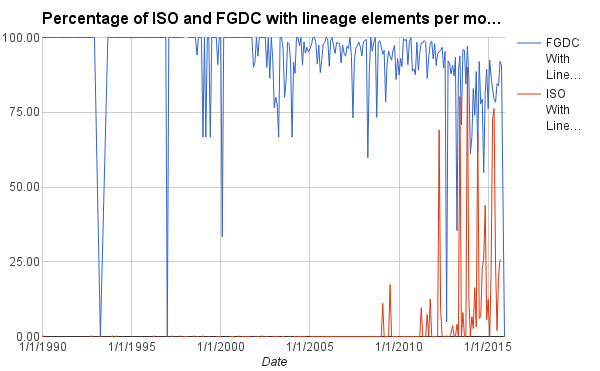

In [6]:
from IPython.display import Image
Image(filename='screenshots/pct_iso_fgdc_w_lineage_by_month_1990s_on.png') 

In [4]:
# but we're going to bin by year instead
# to try to get a reasonable graphic
# AND it's the total number of responses per year NOT the number by protocol

sql = """
with m as (
	select response_id, existences->'lineage' as has_lineage,
		existences->'attribute' as has_attribute,
		existences->'data_quality' as has_quality,
		existences->'metadata' as has_metadata
	from metadata_completeness
), i as (
	select d.response_id, jsonb_array_elements(d.identity::jsonb) ident
	from identities d
	where d.identity is not null
), a as (
	select extract(year from metadata_age) as the_year,
		count(id) as responses_per_year
	from responses
	where metadata_age is not null
	group by the_year
)

select i.ident->'protocol' as protocol, date_trunc('year', r.metadata_age)::date as published,
	sum(case when m.has_lineage::text = 'true' then 1 else 0 end) as count_w_lineage,
	sum(case when m.has_lineage::text != 'true' then 1 else 0 end) as count_wo_lineage,
	round((sum(case when m.has_lineage::text = 'true' then 1. else 0. end) / min(a.responses_per_year)::numeric) * 100.0, 2) as pct_of_total,
	min(a.responses_per_year) as total_responses_per_year
from responses r join m on m.response_id = r.id
	join i on i.response_id = r.id
	join a on a.the_year = extract(year from r.metadata_age)
where extract(year from r.metadata_age) > 1990 and extract(year from r.metadata_age) < 2016
group by protocol, published
order by date_trunc('year', r.metadata_age)::date ASC, protocol;
"""

df = pd.read_sql(sql, engine)
df

,protocol,published,count_w_lineage,count_wo_lineage,pct_of_total,total_responses_per_year
0,FGDC,1991-01-01,23,0,100.00,23
1,FGDC,1992-01-01,28,0,93.33,30
2,ISO,1992-01-01,0,2,0.00,30
3,FGDC,1993-01-01,32,1,88.89,36
4,ISO,1993-01-01,0,3,0.00,36
5,FGDC,1994-01-01,31,0,96.88,32
6,ISO,1994-01-01,0,1,0.00,32
7,FGDC,1995-01-01,33,0,100.00,33
8,FGDC,1996-01-01,44,0,95.65,46
9,ISO,1996-01-01,0,2,0.00,46


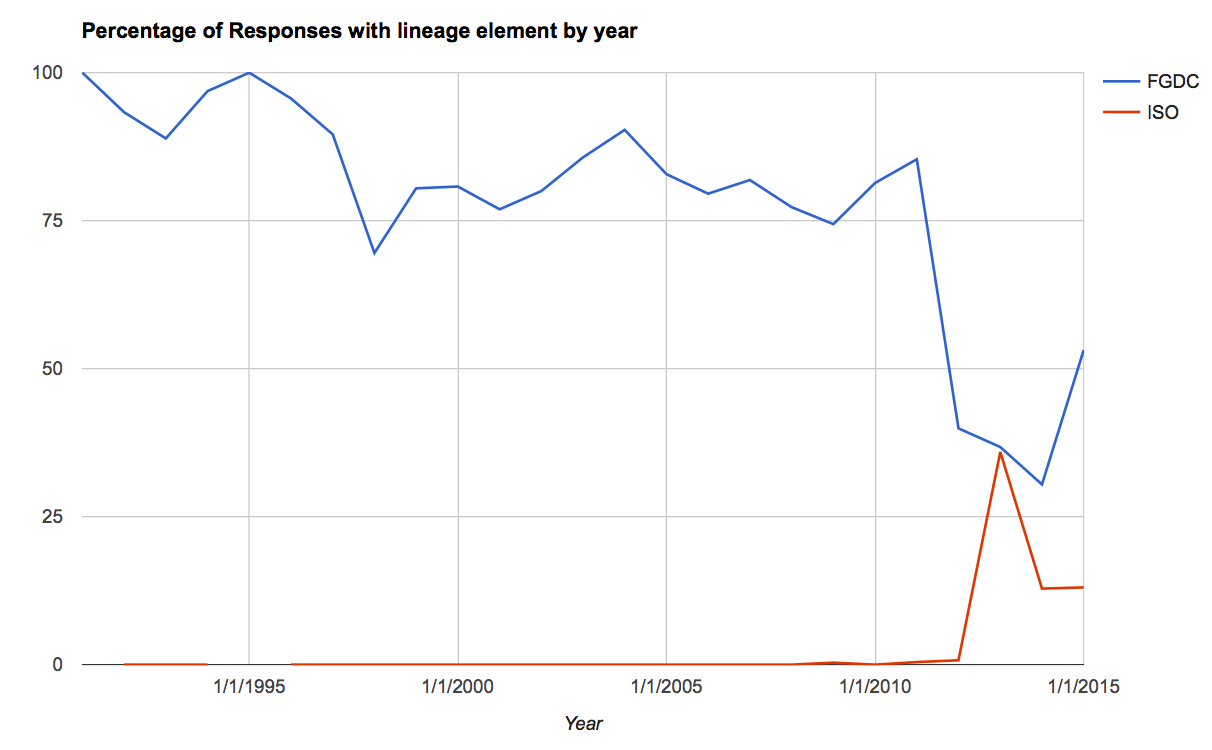

In [7]:
from IPython.display import Image
Image(filename='screenshots/pct_responses_w_lineage_by_year.png') 

# NOTE: this is percentage of FGDC && ISO responses per year!

In [8]:
# adding host in (not executed, but for reference)

sql = """
with m as (
	select response_id, existences->'lineage' as has_lineage,
		existences->'attribute' as has_attribute,
		existences->'data_quality' as has_quality,
		existences->'metadata' as has_metadata
	from metadata_completeness
), i as (
	select d.response_id, jsonb_array_elements(d.identity::jsonb) ident
	from identities d
	where d.identity is not null
), a as (
	select extract(year from metadata_age) as the_year,
		count(id) as responses_per_year
	from responses
	where metadata_age is not null
	group by the_year
)

select r.host, i.ident->'protocol' as protocol, date_trunc('year', r.metadata_age)::date as published,
	sum(case when m.has_lineage::text = 'true' then 1 else 0 end) as count_w_lineage,
	sum(case when m.has_lineage::text != 'true' then 1 else 0 end) as count_wo_lineage,
	round((sum(case when m.has_lineage::text = 'true' then 1. else 0. end) / min(a.responses_per_year)::numeric) * 100.0, 2) as pct_of_total,
	min(a.responses_per_year) as total_responses_per_year
from responses r join m on m.response_id = r.id
	join i on i.response_id = r.id
	join a on a.the_year = extract(year from r.metadata_age)
where extract(year from r.metadata_age) > 1990 and extract(year from r.metadata_age) < 2016
group by r.host, protocol, published
order by r.host, date_trunc('year', r.metadata_age)::date ASC, protocol;
"""

So I'm not going to do this for the other 2 (ignoring the attribute one given that we don't identify FGDC as vector or raster and it's not in the ISO). I'll add the larger questions for data quality and we can see what's odd (or not)

TODO: add the existence info for data quality


<a id='protocol_procsteps_updated'></a>
####Updated Lineage counts -> ISO has processing steps or has lineage statement


In [1]:
# the fgdc v iso, with the lineage statement for iso
sql = """
with i as (
	select d.response_id, (e.value->'protocol')::text as ident
	from identities d, jsonb_array_elements(d.identity::jsonb) e
	where d.identity is not null 
		and (e.value->>'protocol' = 'ISO' or e.value->>'protocol' = 'FGDC' )
), x as 
(
	with m as
	(
		select response_id, j.value as lineage
		from metadata_completeness, json_array_elements(wordcounts->'lineage') j
		where wordcounts->>'lineage' != '[]'
	)
	select m.response_id, m.lineage->'tokens' as statement_tokens
	from m 
	where (m.lineage->>'tag')::text ilike '%%/dataQualityInfo/DQ_DataQuality/lineage/LI_Lineage/statement/CharacterString%'
)

select 
	case when 
		(c.existences->'lineage')::text::boolean = True 
			or x.statement_tokens is not null 
		then True 
		else False 
	end as the_lineage,
	count(c.response_id),
	i.ident
from metadata_completeness c 
	left outer join x on x.response_id = c.response_id
	left outer join i on i.response_id = c.response_id
group by i.ident, the_lineage;
"""
# df = pd.read_sql(sql, engine)
# df

| Protocol | Count without any Lineage Option    | Count with any Lineage Option     | 
|----------|------|-------| 
| FGDC     | 3246 | 23053 | 
| ISO      | 8659 | 11016 | 


In [ ]:
# 
sql = """
with i as (
	select d.response_id, (e.value->'protocol')::text as ident
	from identities d, jsonb_array_elements(d.identity::jsonb) e
	where d.identity is not null 
		and e.value->>'protocol' = 'ISO'
), x as 
(
	with m as
	(
		select response_id, j.value as lineage
		from metadata_completeness, json_array_elements(wordcounts->'lineage') j
		where wordcounts->>'lineage' != '[]'
	)
	select m.response_id, m.lineage->'tokens' as statement_tokens
	from m 
	where (m.lineage->>'tag')::text ilike '%%/dataQualityInfo/DQ_DataQuality/lineage/LI_Lineage/statement/CharacterString%'
)

select date_trunc('month', r.metadata_age)::date as age,
	case 
		when (c.existences->'lineage')::text::boolean = True then 'Processing Steps'
		when x.statement_tokens is not null then 'Statement'
		else 'No Lineage'
	end as lineage_type,
	count(c.response_id)
from metadata_completeness c 
	left outer join x on x.response_id = c.response_id
	join i on i.response_id = c.response_id
	join responses r on r.id = c.response_id
where i.ident = '"ISO"'
group by age, lineage_type
order by lineage_type, age ASC;
"""

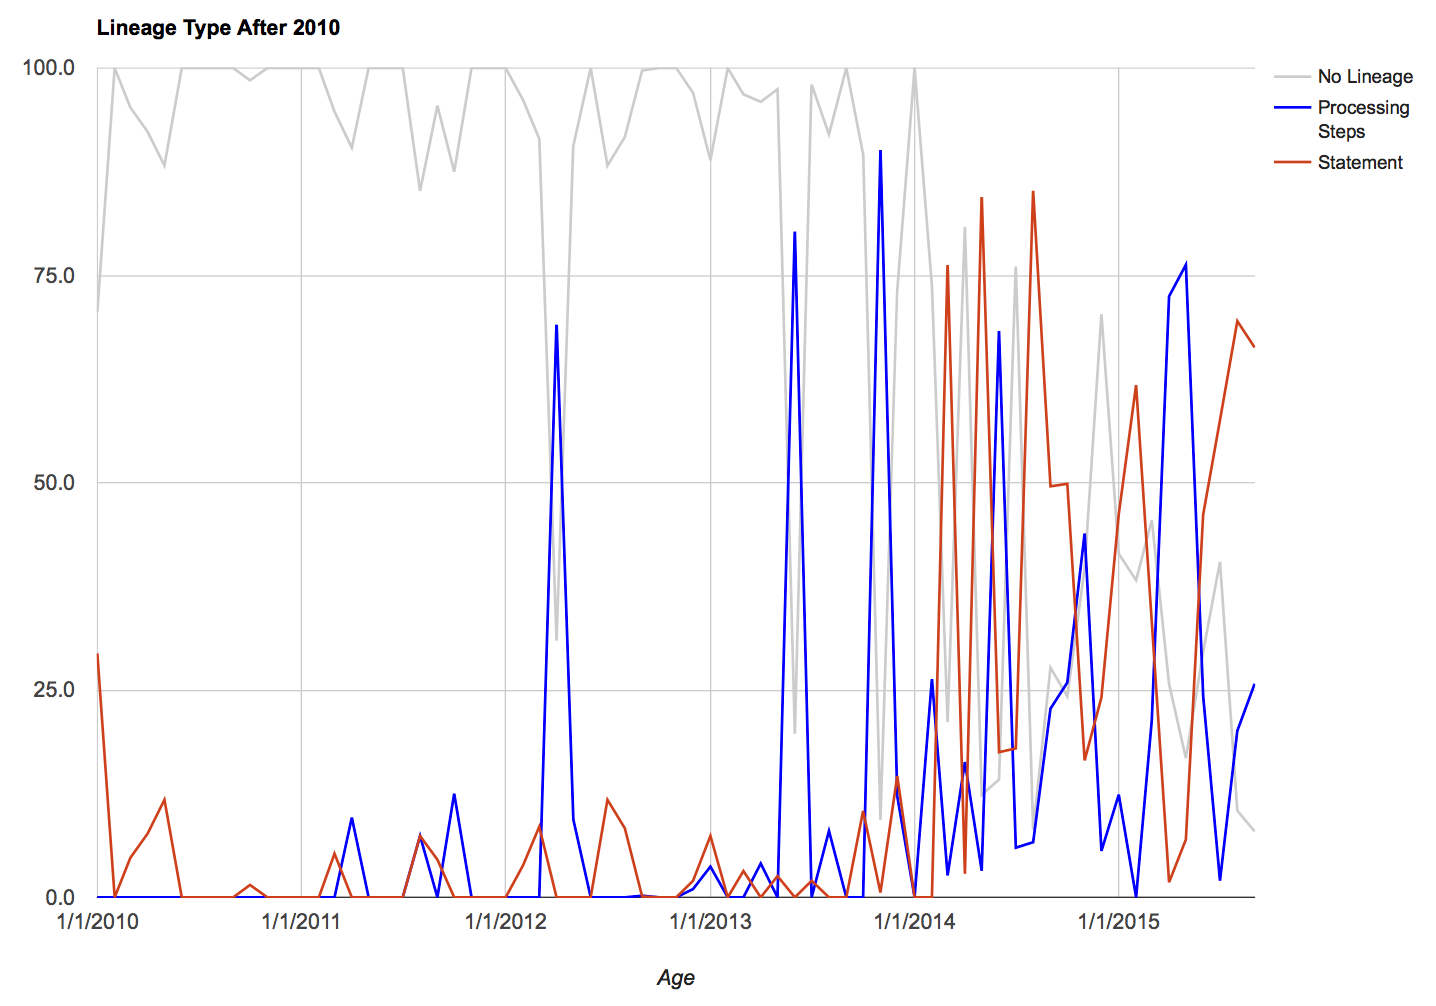

In [4]:
from IPython.display import Image
Image(filename='screenshots/iso_lineages_post2010.png') 

# ISO Lineage types per month from 2010 on 
# (very low counts, 1-5, per month prior to that)

Not much of a trend - both types of lineage structures are more used over the last two years, but I suspect it's a server by server trend. So one last check - bin by host.

In [ ]:
sql = """
with i as (
	select d.response_id, (e.value->'protocol')::text as ident
	from identities d, jsonb_array_elements(d.identity::jsonb) e
	where d.identity is not null 
		and e.value->>'protocol' = 'ISO'
), x as 
(
	with m as
	(
		select response_id, j.value as lineage
		from metadata_completeness, json_array_elements(wordcounts->'lineage') j
		where wordcounts->>'lineage' != '[]'
	)
	select m.response_id, m.lineage->'tokens' as statement_tokens
	from m 
	where (m.lineage->>'tag')::text ilike '%%/dataQualityInfo/DQ_DataQuality/lineage/LI_Lineage/statement/CharacterString%'
)

select r.host,
	case 
		when (c.existences->'lineage')::text::boolean = True then 'Processing Steps'
		when x.statement_tokens is not null then 'Statement'
		else 'No Lineage'
	end as lineage_type,
	count(c.response_id)
from metadata_completeness c 
	left outer join x on x.response_id = c.response_id
	join i on i.response_id = c.response_id
	join responses r on r.id = c.response_id
where i.ident = '"ISO"'
group by r.host, lineage_type
order by r.host, lineage_type;
"""

The results. It is server implementation - the systems that are known aggregators have both processing steps and statements, those that aren't tend to have one or the other, assuming they have a lineage element at all. I am sticking with the switch to statement as, at least partly, due to interface decisions.


| Host                                | No Lineage | Processing Steps | Statement | 
|-------------------------------------|------------|------------------|-----------| 
| 217.23.233.67                       |            |                  | 3         | 
| arcticlcc.org                       | 1          |                  |           | 
| bluehub.jrc.ec.europa.eu            | 13         |                  | 123       | 
| ca.water.usgs.gov                   | 1          |                  |           | 
| catalog.data.gov                    | 3934       | 767              | 186       | 
| catalogue.datalocale.fr             |            |                  | 1         | 
| cida.usgs.gov                       |            |                  | 2         | 
| climate-adapt.eea.europa.eu         |            |                  | 1         | 
| coast.noaa.gov                      | 234        |                  |           | 
| coastwatch.pfeg.noaa.gov            | 78         |                  | 255       | 
| crack.seismo.unr.edu                | 3          | 7                |           | 
| d1opzmrrdjgef4.cloudfront.net       | 1          |                  |           | 
| data-search.nerc.ac.uk              | 10         |                  | 678       | 
| data.boisestate.edu                 | 4          |                  |           | 
| data.daff.gov.au                    | 5          |                  | 18        | 
| data.doi.gov                        | 43         |                  |           | 
| data.fao.org                        |            |                  | 1         | 
| data.gov.au                         | 17         |                  | 7         | 
| data.ioos.us                        |            |                  | 184       | 
| data.nanoos.org                     | 18         |                  | 4         | 
| data.noaa.gov                       | 985        | 83               | 176       | 
| data.nodc.noaa.gov                  | 101        |                  |           | 
| data.ottawa.ca                      | 6          |                  | 1         | 
| data.satapps.org                    |            |                  | 37        | 
| data.ulm.de                         |            | 46               |           | 
| datapoint.metoffice.gov.uk          |            |                  | 25        | 
| dataxfer.stanford.edu               | 4          |                  |           | 
| dcsu059g9fk65.cloudfront.net        |            |                  | 5         | 
| discomap.eea.europa.eu              |            |                  | 1         | 
| docs.lib.noaa.gov                   | 2          |                  |           | 
| donnees.ec.gc.ca                    | 5          |                  |           | 
| ecco.jpl.nasa.gov                   |            |                  | 147       | 
| ecowatch.ncddc.noaa.gov             | 2          |                  | 74        | 
| edg.epa.gov                         |            |                  | 67        | 
| edgar.jrc.ec.europa.eu              |            |                  | 2         | 
| epa.gov                             | 1          |                  |           | 
| ferret.pmel.noaa.gov                | 1          |                  | 15        | 
| gar.lternet.edu                     |            | 20               |           | 
| geoport.whoi.edu                    | 45         |                  | 67        | 
| gis.breconbeacons.org               | 1          |                  | 3         | 
| gisdata.nd.gov                      | 1          |                  |           | 
| gsics.eumetsat.int                  |            |                  | 10        | 
| gstore.unm.edu                      | 404        | 269              |           | 
| inport.nmfs.noaa.gov                | 588        | 188              |           | 
| inspire.halton.gov.uk               | 2          |                  | 1         | 
| locationmde.data.gov.uk             | 28         |                  | 153       | 
| map.richmond.gov.uk                 | 3          |                  |           | 
| maps.bristol.gov.uk                 |            |                  | 10        | 
| maps.derby.gov.uk                   |            |                  | 7         | 
| maps.norfolk.gov.uk                 |            |                  | 19        | 
| maps.northlincs.gov.uk              | 1          |                  |           | 
| mcm.lternet.edu                     | 2          | 74               |           | 
| meta.geo.census.gov                 | 46         | 1681             |           | 
| mrdata.usgs.gov                     | 23         |                  |           | 
| ngdc.noaa.gov                       |            | 2                |           | 
| oos.soest.hawaii.edu                | 27         | 2                | 299       | 
| opendata.euskadi.eus                | 15         |                  | 662       | 
| opendata.thessaloniki.gr            |            |                  | 6         | 
| osmc.noaa.gov                       | 11         |                  | 16        | 
| pacioos-mapserver2.ancl.hawaii.edu  |            |                  | 13        | 
| partnerdataexport.ccw.gov.uk        |            |                  | 1         | 
| portal.oceannet.org                 | 2          |                  | 96        | 
| repository.stategeothermaldata.org  | 12         |                  | 2331      | 
| rsg.pml.ac.uk                       | 1          |                  | 5         | 
| sero.nmfs.noaa.gov                  |            | 32               |           | 
| stellwagen.er.usgs.gov              |            |                  | 109       | 
| taskman.eionet.europa.eu            |            |                  | 2         | 
| tds.glos.us                         |            |                  | 4         | 
| upwell.pfeg.noaa.gov                | 2          |                  | 117       | 
| vislab-ccom.unh.edu                 | 1          |                  |           | 
| vogis.cnv.at                        |            |                  | 1         | 
| webarchive.nationalarchives.gov.uk  | 7          |                  | 130       | 
| wis.wmo.int                         | 21         |                  | 2         | 
| www.add.scar.org                    | 1          |                  |           | 
| www.admiralty.co.uk                 | 3          |                  | 25        | 
| www.aoncadis.org                    | 31         |                  |           | 
| www.bco-dmo.org                     |            | 1                |           | 
| www.beacons-npa.gov.uk              |            |                  | 2         | 
| www.charts.noaa.gov                 | 430        |                  |           | 
| www.coris.noaa.gov                  | 56         | 205              | 2         | 
| www.data.gouv.fr                    |            |                  | 2         | 
| www.datalocale.fr                   |            |                  | 1         | 
| www.datanorthyorkshire.org          |            |                  | 1         | 
| www.deq.state.va.us                 |            | 1                |           | 
| www.earthsystemgrid.org             | 93         |                  |           | 
| www.eea.europa.eu                   |            |                  | 20        | 
| www.epa.gov                         | 1          |                  |           | 
| www.euskadi.eus                     | 8          |                  | 281       | 
| www.ga.gov.au                       |            |                  | 1         | 
| www.geoportal.rlp.de                | 3          |                  | 1         | 
| www.geoviqua.org                    |            | 2                |           | 
| www.gogeo.ac.uk                     |            |                  | 1         | 
| www.lehendakaritza.ejgv.euskadi.eus |            |                  | 36        | 
| www.marine-geo.org                  | 5          |                  |           | 
| www.nauticalcharts.noaa.gov         | 1          |                  |           | 
| www.ncddc.noaa.gov                  | 111        | 204              |           | 
| www.ngdc.noaa.gov                   | 47         | 90               | 855       | 
| www.ngu.no                          |            | 6                |           | 
| www.rijkswaterstaat.nl              |            |                  | 6         | 
| www.salford.gov.uk                  |            |                  | 14        | 
| www.seadatanet.org                  |            |                  | 3         | 
| www.sitr.regione.sicilia.it         | 2          |                  |           | 
| www.usgs.gov                        | 1155       | 5                |           | 
| www1.ncdc.noaa.gov                  |            |                  | 1         | 
| www1.usgs.gov                       |            |                  | 2         | 


<a id='distributions'></a>
### Distributions

I'll note that these numbers are preliminary - the OGC HEAD response issue remains and FTP URLs fall under the 900 errors (possibly).

Also, when these are binned by host - these are **not** links at that host, these are links found in metadata at that host. We are not talking anything about those links other than referenced from a harvested metadata record and still available or not.

THIS IS THE LINKROT **WITHIN** THE METADATA QUESTION.

In [9]:
# for hosts with online distributions (number of distribution links per host)

sql = """
with m as (
	select response_id, online
	from metadata_completeness,
		json_array_elements(distributions->'online') online
)
select r.host, count(m.online) as num_hrefs
from responses r join m on m.response_id = r.id
group by r.host
order by num_hrefs DESC;
"""

df = pd.read_sql(sql, engine)
df[:25]

,host,num_hrefs
0,coastwatch.pfeg.noaa.gov,11907
1,catalog.data.gov,11511
2,earthquake.usgs.gov,8550
3,data.ioos.us,7176
4,oos.soest.hawaii.edu,7098
5,www.ngdc.noaa.gov,5665
6,gstore.unm.edu,5138
7,www.charts.noaa.gov,5042
8,bluehub.jrc.ec.europa.eu,4960
9,upwell.pfeg.noaa.gov,4518


In [10]:
# better, the average number of distro hrefs per response for a host

sql = """
with m as (
	select response_id, count(online) as num_per_response
	from metadata_completeness,
		json_array_elements(distributions->'online') online
	group by response_id
)
select r.host, round(avg(m.num_per_response), 2) as avg_hrefs
from responses r join m on m.response_id = r.id
where r.host is not null
group by r.host
order by avg_hrefs DESC;
"""

df = pd.read_sql(sql, engine)
df[:25]

,host,avg_hrefs
0,dataxfer.stanford.edu,20.33
1,data.ioos.us,19.50
2,osmc.noaa.gov,18.69
3,upwell.pfeg.noaa.gov,18.59
4,www1.usgs.gov,18.50
5,bluehub.jrc.ec.europa.eu,18.24
6,coastwatch.pfeg.noaa.gov,18.10
7,ecowatch.ncddc.noaa.gov,17.55
8,data.nanoos.org,17.23
9,pacioos-mapserver2.ancl.hawaii.edu,17.13


Of 172 hosts with hrefs, only 13 average more than 10 per record (that's a lot of distribution links). 

So. These linkrot checks - we can't really do much about what they are (I could make some broad guesses from the URL - WxS patterns, filenames at the end, FTP) but not a whole lot else right now. I'm going to keep it binning by host and by year.

In [ ]:
# linkrot binned by host
# note the 999 code rounded up to a 1000 (still the exception)

sql = """
with m as (
	select response_id, round((online->>'status')::text::int, -2) as status_code
	from metadata_completeness,
		json_array_elements(distributions->'online') online
)
select r.host, m.status_code, count(m.status_code) as num_per_status
from responses r join m on m.response_id = r.id
group by r.host, m.status_code
order by r.host, m.status_code ASC;
"""

# also much faster away from pandas (sorry, that is bad - can't see the work i know)

####Status Codes by Host for any host with more than 100 distribution links


| Host                                | 200  | 300  | 400  | 500 | 900  | Grand Total | 
|-------------------------------------|------|------|------|-----|------|-------------| 
| coastwatch.pfeg.noaa.gov            | 8267 | 46   |      | 85  | 3509 | 11907       | 
| catalog.data.gov                    | 6852 | 1256 | 1809 | 66  | 1528 | 11511       | 
| earthquake.usgs.gov                 | 961  | 610  | 6913 |     | 66   | 8550        | 
| data.ioos.us                        | 7173 |      |      |     | 3    | 7176        | 
| oos.soest.hawaii.edu                | 5889 | 367  | 97   | 34  | 711  | 7098        | 
| www.ngdc.noaa.gov                   | 5535 | 93   | 23   | 1   | 13   | 5665        | 
| gstore.unm.edu                      | 5025 | 85   |      | 9   | 19   | 5138        | 
| www.charts.noaa.gov                 | 5039 |      |      |     | 3    | 5042        | 
| bluehub.jrc.ec.europa.eu            | 4680 |      | 280  |     |      | 4960        | 
| upwell.pfeg.noaa.gov                | 4069 |      |      | 9   | 440  | 4518        | 
| opendata.euskadi.eus                | 1625 | 1129 | 47   | 22  | 311  | 3134        | 
| data.noaa.gov                       | 2029 | 526  | 126  | 2   | 364  | 3047        | 
| ecowatch.ncddc.noaa.gov             | 2668 |      |      |     |      | 2668        | 
| repository.stategeothermaldata.org  | 1088 | 210  | 780  | 253 | 297  | 2628        | 
| meta.geo.census.gov                 | 2391 | 56   | 56   |     | 79   | 2582        | 
| data.usgs.gov                       | 1394 | 92   | 95   | 9   | 95   | 1685        | 
| water.usgs.gov                      | 1611 | 38   | 11   | 1   | 16   | 1677        | 
| mrdata.usgs.gov                     | 1065 | 176  | 7    |     | 200  | 1448        | 
| www.euskadi.eus                     | 699  | 436  | 28   | 18  | 133  | 1314        | 
| data-search.nerc.ac.uk              | 1027 | 170  | 21   | 2   | 40   | 1260        | 
| osmc.noaa.gov                       | 960  | 4    | 4    |     | 41   | 1009        | 
| www.seismo.unr.edu                  | 345  |      | 525  |     |      | 870         | 
| woodshole.er.usgs.gov               | 53   | 668  | 11   | 3   | 84   | 819         | 
| www.coris.noaa.gov                  | 414  | 285  | 6    |     | 104  | 809         | 
| inport.nmfs.noaa.gov                | 770  | 3    | 14   | 5   | 12   | 804         | 
| data.nanoos.org                     | 725  |      | 33   |     |      | 758         | 
| pubs.usgs.gov                       | 393  | 25   | 53   | 9   | 61   | 541         | 
| nrdata.nps.gov                      | 77   |      | 441  |     | 2    | 520         | 
| pacioos-mapserver2.ancl.hawaii.edu  | 411  |      |      |     |      | 411         | 
| data.doi.gov                        | 38   | 10   | 17   | 1   | 334  | 400         | 
| sofia.usgs.gov                      | 323  | 23   | 1    |     | 1    | 348         | 
| www.idwr.idaho.gov                  | 133  | 11   | 17   |     | 178  | 339         | 
| locationmde.data.gov.uk             | 274  | 7    | 15   |     | 24   | 320         | 
| coast.noaa.gov                      | 120  | 50   | 30   |     | 117  | 317         | 
| data.nodc.noaa.gov                  | 13   | 197  |      |     | 100  | 310         | 
| ecco.jpl.nasa.gov                   | 147  | 147  |      |     |      | 294         | 
| www.aeic.alaska.edu                 | 214  |      | 74   |     |      | 288         | 
| www.ncddc.noaa.gov                  | 162  | 3    | 100  |     | 11   | 276         | 
| webarchive.nationalarchives.gov.uk  | 225  | 20   | 19   |     | 3    | 267         | 
| geoport.whoi.edu                    | 95   | 112  |      | 11  | 6    | 224         | 
| stellwagen.er.usgs.gov              | 70   | 109  | 30   |     | 9    | 218         | 
| www.nodc.noaa.gov                   | 13   | 5    | 1    |     | 188  | 207         | 
| www.lehendakaritza.ejgv.euskadi.eus | 119  | 65   |      |     | 11   | 195         | 
| dataxfer.stanford.edu               | 154  |      | 23   |     | 6    | 183         | 
| edg.epa.gov                         | 41   | 85   | 16   |     | 30   | 172         | 
| data.daff.gov.au                    | 144  | 12   | 15   |     |      | 171         | 
| data.gov.au                         | 68   | 34   | 1    |     | 60   | 163         | 
| arcticlcc.org                       | 116  | 24   | 6    |     | 3    | 149         | 
| mcm.lternet.edu                     | 144  |      |      |     | 1    | 145         | 
| cloud.insideidaho.org               | 40   | 13   | 51   |     | 38   | 142         | 
| mslapps.mt.gov                      | 46   | 4    | 5    | 3   | 77   | 135         | 
| portal.oceannet.org                 | 36   | 39   |      |     | 34   | 109         | 


In [ ]:
# back to binning by age

sql = """
with m as (
	select response_id, round((online->>'status')::text::int, -2) as status_code
	from metadata_completeness,
		json_array_elements(distributions->'online') online
), a as (
	select extract(year from metadata_age) as the_year,
		count(id) as responses_per_year
	from responses
	where metadata_age is not null
	group by the_year
)
select a.the_year, m.status_code, count(m.status_code) as num_per_status
from responses r join m on m.response_id = r.id
	join a on a.the_year = extract(year from r.metadata_age) 
where r.metadata_age is not null
group by a.the_year, m.status_code
order by a.the_year, m.status_code ASC;
"""

And it's, again, not the age of the thing at the link checked, but the age of the metadata it was in. So we can assume that is was 200 at the metadata publication date but can't know. Also, issues with publication date - 1964 is a little early for functional metadata portals. Those dates for this analysis are sketchy because of that - we have no idea when the metadata record was published, for some of the older ones, I'm guessing that the information in the files came from some other format or that the metadata date is, incorrectly conceptually, set to the dataset date. 

That bit of sql pivoted:

| Year | 200   | 300  | 400  | 500 | 1000 | Total  | 
|------|-------|------|------|-----|------|--------| 
| 1900 | 9     |      |      |     |      | 9      | 
| 1964 |       |      | 3    |     |      | 3      | 
| 1973 |       |      | 96   |     |      | 96     | 
| 1974 |       |      | 63   |     |      | 63     | 
| 1975 |       |      | 87   |     |      | 87     | 
| 1976 |       |      | 84   |     |      | 84     | 
| 1977 |       |      | 78   |     |      | 78     | 
| 1978 |       |      | 102  |     |      | 102    | 
| 1979 |       |      | 90   |     |      | 90     | 
| 1980 |       |      | 102  |     |      | 102    | 
| 1981 |       |      | 81   |     |      | 81     | 
| 1982 |       |      | 96   |     |      | 96     | 
| 1983 |       |      | 99   |     |      | 99     | 
| 1984 |       |      | 87   |     |      | 87     | 
| 1985 |       |      | 75   |     |      | 75     | 
| 1986 |       |      | 102  |     |      | 102    | 
| 1987 |       |      | 108  |     |      | 108    | 
| 1988 |       |      | 84   |     |      | 84     | 
| 1989 |       |      | 102  |     |      | 102    | 
| 1990 |       | 5    | 102  |     |      | 107    | 
| 1991 |       |      | 69   |     |      | 69     | 
| 1992 | 3     | 5    | 72   |     |      | 80     | 
| 1993 |       |      | 96   |     |      | 96     | 
| 1994 |       | 3    | 81   |     | 1    | 85     | 
| 1995 | 1     |      | 96   |     |      | 97     | 
| 1996 |       |      | 102  |     | 12   | 114    | 
| 1997 | 7     | 6    | 105  |     | 5    | 123    | 
| 1998 | 38    | 12   | 122  | 7   | 17   | 196    | 
| 1999 | 26    | 30   | 90   | 1   | 3    | 150    | 
| 2000 | 22    | 4    | 101  |     | 11   | 138    | 
| 2001 | 37    | 13   | 100  | 1   | 50   | 201    | 
| 2002 | 60    | 9    | 110  | 13  | 19   | 211    | 
| 2003 | 98    | 15   | 159  | 6   | 70   | 348    | 
| 2004 | 600   | 71   | 696  | 10  | 260  | 1637   | 
| 2005 | 271   | 138  | 548  | 7   | 110  | 1074   | 
| 2006 | 398   | 217  | 664  | 3   | 133  | 1415   | 
| 2007 | 658   | 418  | 794  | 4   | 162  | 2036   | 
| 2008 | 761   | 214  | 917  | 6   | 99   | 1997   | 
| 2009 | 640   | 145  | 486  | 4   | 169  | 1444   | 
| 2010 | 1307  | 226  | 516  | 4   | 225  | 2278   | 
| 2011 | 1194  | 276  | 493  |     | 192  | 2155   | 
| 2012 | 1217  | 475  | 690  |     | 334  | 2716   | 
| 2013 | 2065  | 345  | 411  | 7   | 279  | 3107   | 
| 2014 | 14145 | 2933 | 709  | 47  | 1492 | 19326  | 
| 2015 | 43977 | 1404 | 1077 | 154 | 5800 | 52412  | 
| 2030 |       | 12   |      |     |      | 12     | 
| 2040 |       |      |      |     | 1    | 1      | 
| 8888 | 1     |      |      |     |      | 1      | 
| 9999 | 5     | 2    | 45   |     | 3    | 55     | 


Just to show. The 1964 record is from the USGS shakemap service:

http://earthquake.usgs.gov/earthquakes/shakemap/ak/shake/1964_se/download/metadata.xml

It is for an event in 1964 (so the one assumption is good - it's the dataset data and not the metadata publication date). The question, then, is how many records from prior to 2000 are shakemap records and affected by a site redesign (no redirects, they've redesigned the access points to be javascript map access). [I didn't see anything that looked like an obvious access point to this metadata either.]

Anyway, a chart of the percents per year.

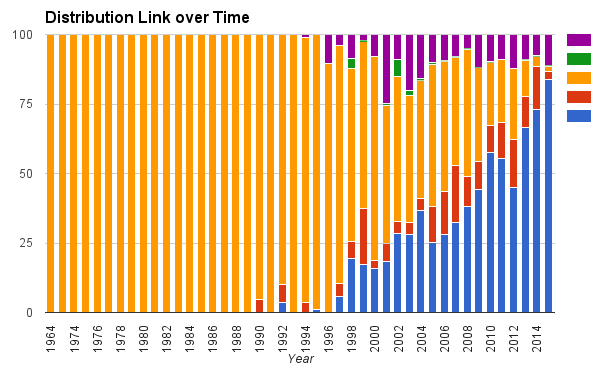

In [5]:
from IPython.display import Image
Image(filename='screenshots/distro_linkrot_per_year.png', width=900) 

Ok, I have NO IDEA why gsheets cuts off the legend text EVERY TIME but for now, blue is 200, red 300, orange 400, green 500 and purple 900.

I think it's safer to exclude the shakemap responses and make a second chart before haring off with "look at that decline!" 

In [ ]:
# to exclude the shakemap xml
sql = """
with m as (
	select response_id, round((online->>'status')::text::int, -2) as status_code
	from metadata_completeness,
		json_array_elements(distributions->'online') online
), a as (
	select extract(year from metadata_age) as the_year,
		count(id) as responses_per_year
	from responses
	where metadata_age is not null and host != 'earthquake.usgs.gov'
	group by the_year
)
select a.the_year, m.status_code, count(m.status_code) as num_per_status
from responses r join m on m.response_id = r.id
	join a on a.the_year = extract(year from r.metadata_age) 
where r.metadata_age is not null
group by a.the_year, m.status_code
order by a.the_year, m.status_code ASC;
"""

Same pivot table, sans shakemaps:

| Year | 200   | 300  | 400  | 500 | 900  | Total | 
|------|-------|------|------|-----|------|-------| 
| 1986 |       |      | 102  |     |      | 102   | 
| 1990 |       | 5    | 102  |     |      | 107   | 
| 1992 | 3     | 5    | 72   |     |      | 80    | 
| 1993 |       |      | 96   |     |      | 96    | 
| 1994 |       | 3    | 81   |     | 1    | 85    | 
| 1995 | 1     |      | 96   |     |      | 97    | 
| 1996 |       |      | 102  |     | 12   | 114   | 
| 1997 | 7     | 6    | 105  |     | 5    | 123   | 
| 1998 | 38    | 12   | 122  | 7   | 17   | 196   | 
| 1999 | 26    | 30   | 90   | 1   | 3    | 150   | 
| 2000 | 22    | 4    | 101  |     | 11   | 138   | 
| 2001 | 37    | 13   | 100  | 1   | 50   | 201   | 
| 2002 | 60    | 9    | 110  | 13  | 19   | 211   | 
| 2003 | 98    | 15   | 159  | 6   | 70   | 348   | 
| 2004 | 600   | 71   | 696  | 10  | 260  | 1637  | 
| 2005 | 271   | 138  | 548  | 7   | 110  | 1074  | 
| 2006 | 398   | 217  | 664  | 3   | 133  | 1415  | 
| 2007 | 658   | 418  | 794  | 4   | 162  | 2036  | 
| 2008 | 761   | 214  | 917  | 6   | 99   | 1997  | 
| 2009 | 640   | 145  | 486  | 4   | 169  | 1444  | 
| 2010 | 1307  | 226  | 516  | 4   | 225  | 2278  | 
| 2011 | 1194  | 276  | 493  |     | 192  | 2155  | 
| 2012 | 1217  | 475  | 690  |     | 334  | 2716  | 
| 2013 | 2065  | 345  | 411  | 7   | 279  | 3107  | 
| 2014 | 14145 | 2933 | 709  | 47  | 1492 | 19326 | 
| 2015 | 43977 | 1404 | 1077 | 154 | 5800 | 52412 | 


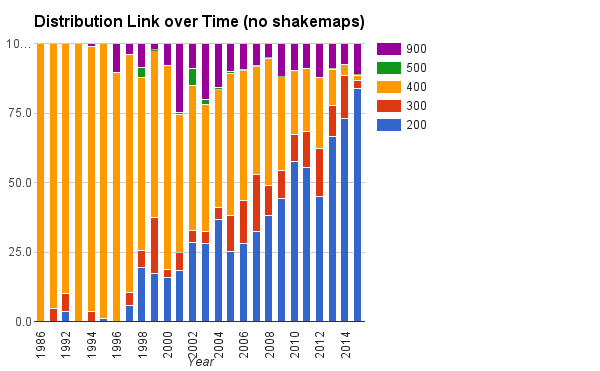

In [1]:
from IPython.display import Image
Image(filename='screenshots/distro_linkrot_per_year_noquakes.png', width=900) 

The pattern doesn't really change when excluding the shakemap XMLs. We lose most of the "older" metadata.

### Tokens 



notes for a minute
19577 iso 19115 recs